Comparing grouping methods 

Code modified from here: https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

In [1]:
%matplotlib notebook


import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import numpy as np
import fitsio
from astropy.io import fits
import numpy.ma as ma
from gPhoton.reference import eclipse_to_paths
from gPhoton.coadd import zero_flag_and_edge
from photutils.aperture import CircularAperture
from photutils.utils import make_random_cmap
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

import pandas as pd 

np.random.seed(0)

In [2]:
# ============
# Importing Datasets 
# ============

e23417 = pd.read_csv("23417_sources_0th_r1_5px.csv")
e17079 = pd.read_csv("17079_sources_0th_r1_5px.csv")
e23456 = pd.read_csv("23456_sources_45th.csv")
e8045 = pd.read_csv("8045_sources_45th.csv")
e35688 = pd.read_csv("35688_sources_0th_r1_5px.csv")
e7986 = pd.read_csv("7986_sources_0th_r1_5px.csv")

e23417 = np.transpose((e23417['xcentroid'], e23417['ycentroid']))
e17079 = np.transpose((e17079['xcentroid'], e17079['ycentroid']))
e23456 = np.transpose((e23456['xcentroid'], e23456['ycentroid']))
e8045 = np.transpose((e8045['xcentroid'], e8045['ycentroid']))
e35688 = np.transpose((e35688['xcentroid'], e35688['ycentroid']))
e7986 = np.transpose((e7986['xcentroid'], e7986['ycentroid']))


In [21]:
#  Image info for background (change data for run here)

positions = e35688 

name = "e35688"

eclipse, band, depth, compression = 35688, "NUV", 30, "rice"

galex_file_paths = eclipse_to_paths(
    eclipse, '/home/bekah/gphoton_working/test_data', depth, compression
)

sources = pd.read_csv("35688_sources_0th_r1_5px.csv")


# image to hdul 
%time hdul = fitsio.FITS(galex_file_paths[band]['image'])
%time cnt, flag, edge = [hdu.read() for hdu in hdul[1:4]]

# masking cnt image
masked_cnt = zero_flag_and_edge(cnt, flag, edge)


# clipping 
def centile_clip(image, centiles=(1, 99)):
    """
    simple clipping function that clips values above and below a given
    percentile range
    """
    finite = np.ma.masked_invalid(image)
    bounds = np.percentile(finite[~finite.mask].data, centiles)
    result = np.ma.clip(finite, *bounds)
    
    if isinstance(image, np.ma.MaskedArray):
        
        return result
    
    return result.data

CPU times: user 160 µs, sys: 12 µs, total: 172 µs
Wall time: 2.26 ms
CPU times: user 139 ms, sys: 28 ms, total: 167 ms
Wall time: 167 ms


In [22]:
# ============
# Compiling Datasets 
# ============

# maybe for future iteration idk 

datasets = [e23417,e17079,e23456,e8045,e35688,e7986]

In [23]:
from astropy.table import QTable, Table, Column 

starlist = Table()

x_0 = list(zip(*positions))[0]
y_0 = list(zip(*positions))[1]

starlist['x_0'] = x_0
starlist['y_0'] = y_0

In [24]:
from photutils.psf.groupstars import DBSCANGroup

eps = 30

%time dbscan_group = DBSCANGroup(crit_separation=eps)

%time dbsc_star_groups = dbscan_group(starlist)

dbsc_star_groups_pd = dbsc_star_groups.to_pandas().groupby(['group_id'])

dbsc_star_groups = dbsc_star_groups.group_by('group_id')
 
dbsc_star_groups_count = dbsc_star_groups_pd.size()

dbsc_star_groups_count.sort_values(ascending=False)

# ------------- calculating ellipses for DBSC group ----------------

extended_dict_dbsc = [] 

for i, group in enumerate(dbsc_star_groups.groups):
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])

        ell = EllipseModel()

        ell.estimate(xypos)
        #print(np.mean(ell.residuals(xypos)))
        xc, yc, a, b, theta = ell.params
        extended_dict_dbsc.append({'xc':xc, 'yc':yc, 'a':a+np.mean(ell.residuals(xypos)), 'b':b+np.mean(ell.residuals(xypos)), 'theta':theta})

       # print("center = ",  (xc, yc))
      #  print("angle of rotation = ",  theta)
     #   print("axes = ", (a,b))
        
extended_sources_dbsc = pd.DataFrame.from_dict(extended_dict_dbsc)

# --------------- convex hull from DBSCANGroup ----------------------

from scipy.spatial import ConvexHull, convex_hull_plot_2d

for i, group in enumerate(dbsc_star_groups.groups):
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])
        hull = ConvexHull(xypos)
        #for simplex in hull.simplices:
            #print(simplex)

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 14.3 µs
CPU times: user 20.1 ms, sys: 3 µs, total: 20.1 ms
Wall time: 18.9 ms


In [25]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

In [26]:
# ============
# Clustering  
# ============

X = positions

min_s = 4
xi = 0.03
min_cluster_size = 80

small = 20 # dbscan eps cutoffs 
big = 40

clust = OPTICS(min_samples=min_s, xi=xi,min_cluster_size=min_cluster_size)

# Run the fit (uses a slope, xi, to define clusters based on slope change in the reachabiltiy diagram)
%time clust.fit(X)


# below here we use eps as the cutoff for defining groups/clusters, like in DBSCAN


labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=small,
)

labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=big,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.88 s


In [27]:
labels_values, counts = np.unique(labels, return_counts=True)
#print(f"the values: {values} for xi, {counts} counts for those values.")

labels_small_values, labels_small_counts = np.unique(labels_050, return_counts=True)

labels_big_values, labels_big_counts = np.unique(labels_200, return_counts=True)

<IPython.core.display.Javascript object>


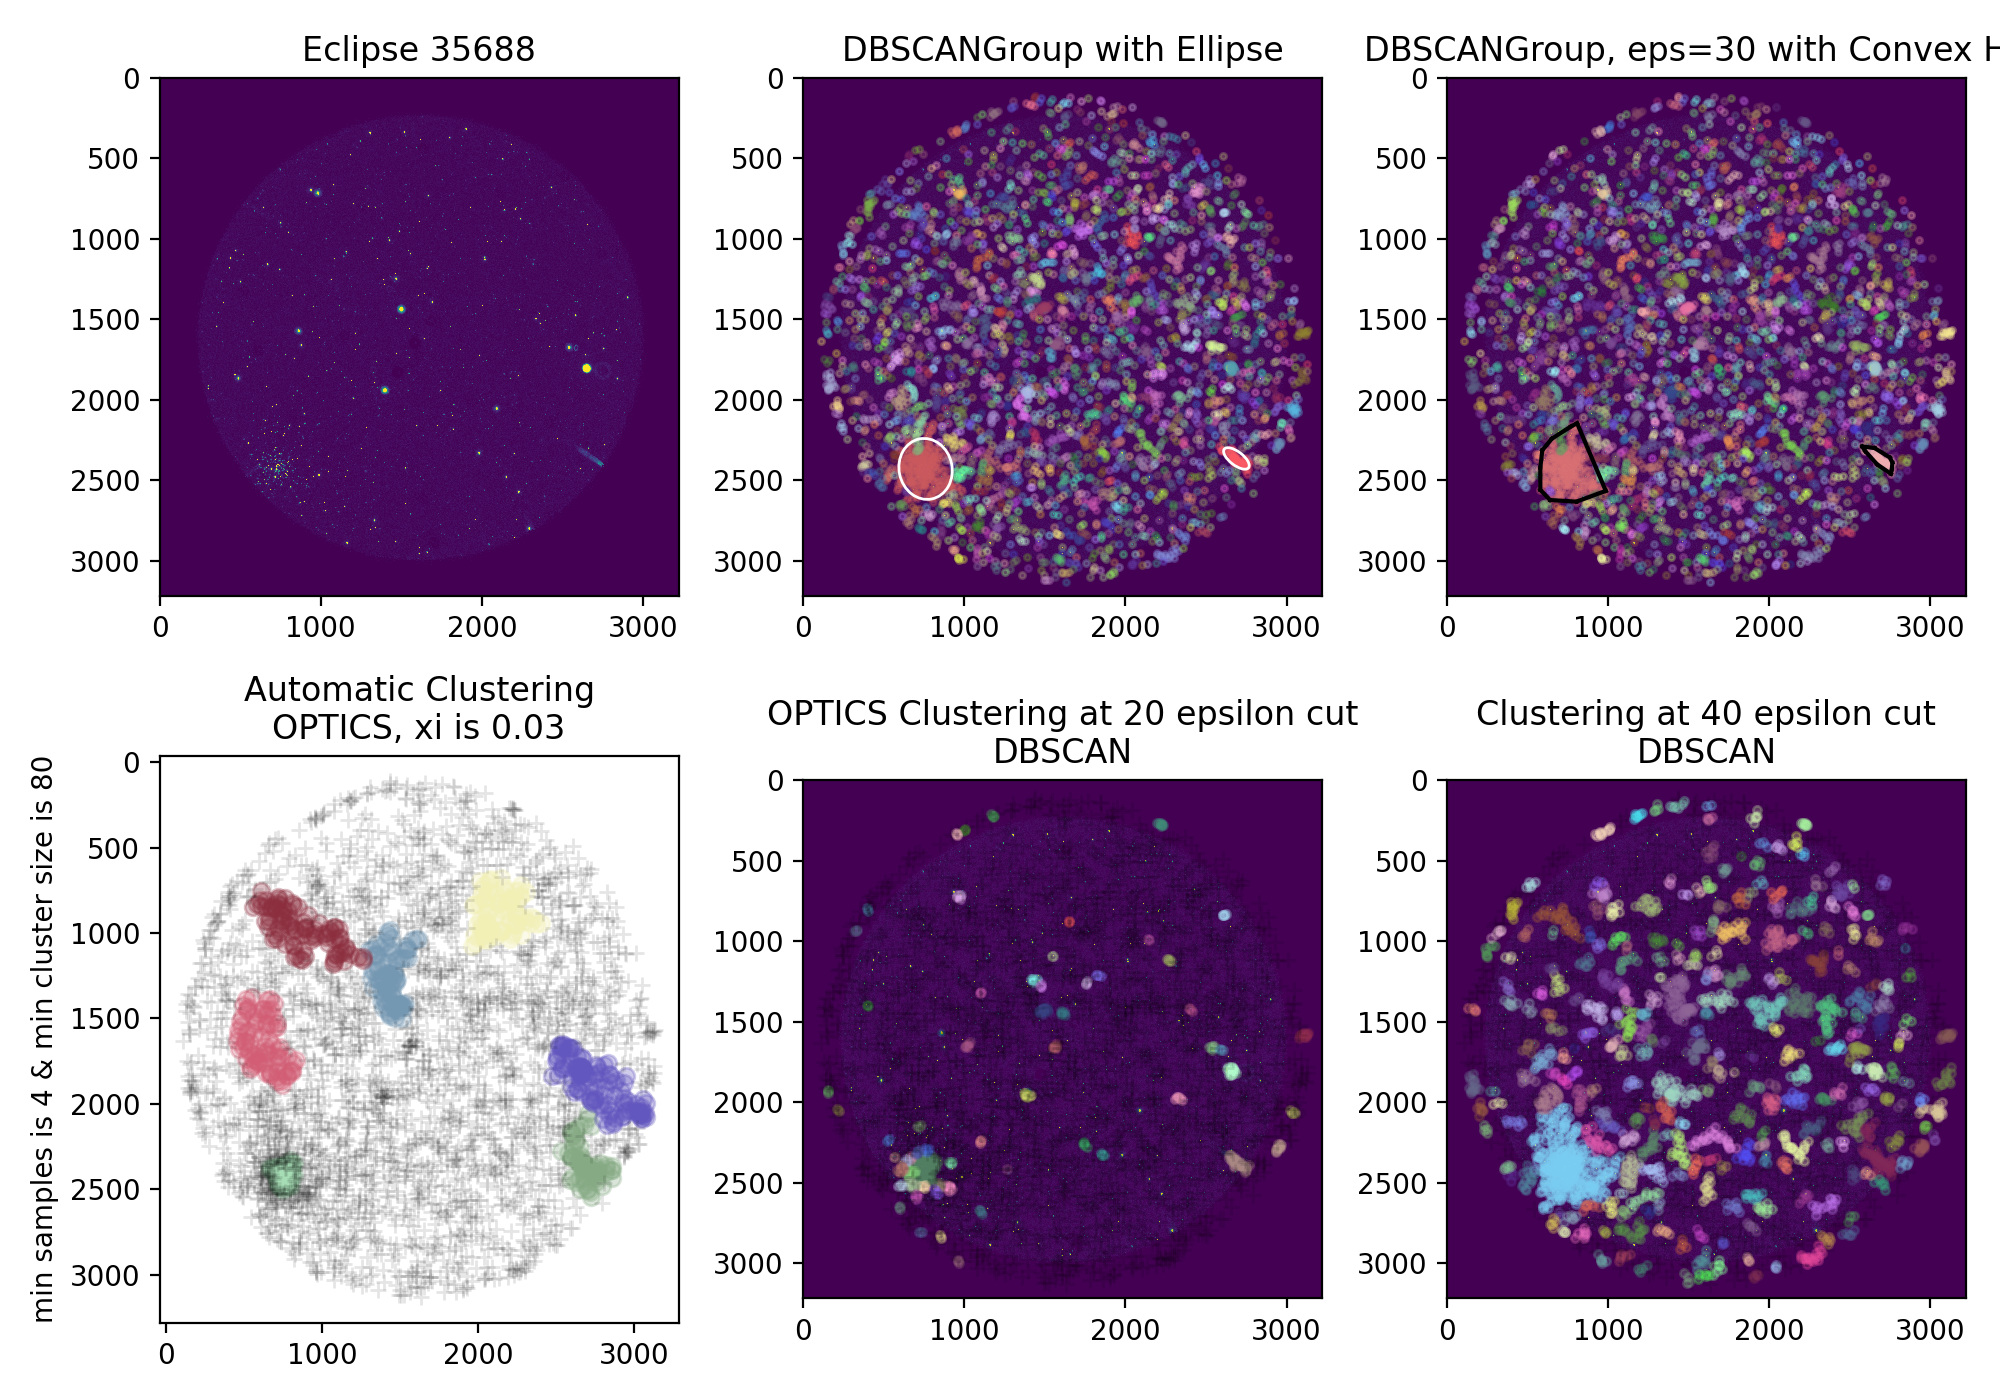

In [28]:

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, 0])
ax5 = plt.subplot(G[0, 1])
ax6 = plt.subplot(G[0, 2])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# GALEX image + DBSCANGroup + ellipse 
ax5.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap = make_random_cmap(ncolors=8000,seed=34)

for i, group in enumerate(dbsc_star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
    #ap = CircularAperture(xypos, r=eps)
    ax5.scatter(xypos[:, 0], xypos[:, 1], color=cmap.colors[i], alpha=0.3, s=5)
    #ap.plot(color=cmap.colors[i],lw=.8)
   # ax5.imshow(ap)
    
for i in range(len(extended_sources_dbsc)):
    ell_patch = Ellipse((extended_sources_dbsc.loc[i,'xc'], extended_sources_dbsc.loc[i,'yc']), 2*extended_sources_dbsc.loc[i,'a'], 2*extended_sources_dbsc.loc[i,'b'], extended_sources_dbsc.loc[i,'theta']*180/np.pi, edgecolor='white', facecolor='none')
    ax5.add_patch(ell_patch)
    
ax5.set_title(f"DBSCANGroup with Ellipse")
    
# GALEX image + DBSCANGroup + ellipse 
ax6.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap = make_random_cmap(ncolors=4000,seed=34)

for i, group in enumerate(dbsc_star_groups.groups):
    xypos = np.transpose([group['x_0'], group['y_0']])
   # ap = CircularAperture(xypos, r=fwhm_db)
    ax6.scatter(xypos[:, 0], xypos[:, 1], color=cmap.colors[i], alpha=0.3, s=5)
    #ap.plot(color=cmap.colors[i],lw=.8)
   # ax5.imshow(ap)
    if len(group) > 20: 
        xypos = np.transpose([group['x_0'], group['y_0']])
        hull = ConvexHull(xypos)
        for simplex in hull.simplices:
            ax6.plot(xypos[simplex, 0], xypos[simplex, 1], 'k-')
ax6.set_title(f"DBSCANGroup, eps={eps} with Convex Hull")

    
# used in reachability plot and OPTICS map 1 
cmap1 = make_random_cmap(ncolors=10000,seed=32)

# OPTICS
ax2.invert_yaxis()
#ax2.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
for klass in range(0, len(labels_values)):
    Xk = X[clust.labels_ == klass]
    ax2.scatter(Xk[:, 0], Xk[:, 1], color=cmap1.colors[klass], alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title(f"Automatic Clustering\nOPTICS, xi is {xi}")
ax2.set_ylabel(f"min samples is {min_s} & min cluster size is {min_cluster_size}")

# DBSCAN at 0.5
ax3.invert_yaxis()
ax3.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap2 = make_random_cmap(ncolors=6000,seed=34)
for klass in range(0, len(labels_small_values)):
    Xk = X[labels_050 == klass]
    ax3.scatter(Xk[:, 0], Xk[:, 1], color=cmap2.colors[klass], alpha=0.3, marker=".")
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title(f"OPTICS Clustering at {small} epsilon cut\nDBSCAN")

# DBSCAN at 2.
ax4.invert_yaxis()
ax4.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
cmap3 = make_random_cmap(ncolors=6000,seed=33)
for klass in range(0, len(labels_big_values)):
    Xk = X[labels_200 == klass]
    ax4.scatter(Xk[:, 0], Xk[:, 1], color=cmap3.colors[klass], alpha=0.3, marker=".")
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title(f"Clustering at {big} epsilon cut\nDBSCAN")

# just the GALEX image, clipped 
ax1.imshow(centile_clip(masked_cnt,centiles=(0,99.9)),interpolation='none')
ax1.set_title(f"Eclipse {eclipse}")


plt.tight_layout()
plt.show()